In [1]:
%load_ext autoreload
%autoreload 2

# Generative Adversarial Networks (GANs)

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
transform = transforms.Compose([
    transforms.Resize(32),  # CIFAR-10 is already 32x32, but this ensures consistency.
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Scale pixel values to [-1, 1]
])
dataset = datasets.CIFAR10(root='../data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4)

Files already downloaded and verified


In [4]:
from DCGAN import DCGAN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
def train_dcgan(latent_dim, num_epochs=25, output_dir=f'output_ld'):
    """
    Train a DCGAN with the specified latent dimension.
    Saves intermediate generated images into a directory.
    Returns the trained DCGAN model.
    """
    # Create an output directory unique to this latent dimension
    save_dir = f"{output_dir}_{latent_dim}"
    os.makedirs(save_dir, exist_ok=True)

    model = DCGAN(latent_dim=latent_dim).to(device)
    optimizerG = optim.Adam(model.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizerD = optim.Adam(model.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)

            # --- Train Discriminator ---
            optimizerD.zero_grad()
            real_pred = model.discriminator(real_images)
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_images = model.generator(noise)
            fake_pred = model.discriminator(fake_images.detach())
            d_loss = model.discriminator_loss(real_pred, fake_pred)
            d_loss.backward()
            optimizerD.step()

            # --- Train Generator ---
            optimizerG.zero_grad()
            fake_pred = model.discriminator(fake_images)
            g_loss = model.generator_loss(fake_pred)
            g_loss.backward()
            optimizerG.step()

            if i % 100 == 0:
                print(f"[LD {latent_dim}][Epoch {epoch+1}/{num_epochs}][{i}/{len(dataloader)}] D_loss: {d_loss.item():.4f}  G_loss: {g_loss.item():.4f}")

        # Save sample generated images at the end of each epoch for qualitative tracking.
        with torch.no_grad():
            fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)
            fake = model.generator(fixed_noise).detach().cpu()
        utils.save_image(fake, os.path.join(save_dir, f"epoch_{epoch+1}.png"), normalize=True)

    return model, save_dir

cuda


In [ ]:
train_dcgan(100)

## DCGAN FID vs latent dim with PCA latent space visualization

In [13]:
def prepare_real_images_folder(folder_path='../data/cifar10_real', num_images=1000):
    """
    Saves num_images (PNG) from the given dataset into folder_path.

    Args:
        dataset (torchvision.datasets): Dataset of real images (e.g., CIFAR10).
        folder_path (str): Target folder to save images.
        num_images (int): Number of images to save.
        batch_size (int): Batch size for the DataLoader.
        num_workers (int): Number of workers for loading data.
    """
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
    os.makedirs(folder_path, exist_ok=True)

    count = 0

    for images, _ in dataloader:
        for i in range(images.size(0)):
            if count >= num_images:
                break
            # Unnormalize the image:
            # Original transform: Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            # To reverse: x = (x * std) + mean, so here:
            img = images[i] * 0.5 + 0.5  # Now pixel values are in [0, 1]
            # Save the image as a PNG.
            img_path = os.path.join(folder_path, f"{count:05d}.png")
            utils.save_image(img, img_path, normalize=False)
            count += 1
        if count >= num_images:
            break

    print(f"Saved {count} images to {folder_path}")

prepare_real_images_folder()

Saved 1000 images to ../data/cifar10_real


In [7]:
import shutil
from pytorch_fid import fid_score

import numpy as np
from scipy import linalg

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """
    Numpy implementation of the Frechet Distance.

    Params:
    -- mu1 : Numpy array containing the activations of the real images.
    -- mu2 : Numpy array containing the activations of the generated images.
    -- sigma1: Covariance matrix for real images.
    -- sigma2: Covariance matrix for generated images.
    -- eps: A small number used to stabilize the calculation.

    Returns:
    -- The Frechet Distance.
    """
    # Add epsilon to the diagonal of covariance matrices to avoid singularities.
    sigma1 += np.eye(sigma1.shape[0]) * eps
    sigma2 += np.eye(sigma2.shape[0]) * eps

    diff = mu1 - mu2
    # Compute the product of covariance matrices and take its matrix square root.
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)

    # If numerical error causes slight imaginary components, discard them.
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = np.sum(diff**2) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

fid_score.calculate_frechet_distance = calculate_frechet_distance

def compute_fid(model, latent_dim, num_images=1000, temp_dir="fid_generated"):
    """
    Generate a number of images with a given model and save them into a temporary folder,
    then compute the FID score comparing those generated images to real images.
    For FID, you need to supply a folder of real images (here assumed to be '../data/cifar10_real')
    which should contain at least `num_images` images saved as PNGs.
    """

    gen_folder = os.path.join(temp_dir, f'ld_{latent_dim}')
    if os.path.exists(gen_folder):
        shutil.rmtree(gen_folder)
    os.makedirs(gen_folder, exist_ok=True)

    model.eval()
    n_batches = num_images // 128
    count = 0
    with torch.no_grad():
        for i in range(n_batches):
            noise = torch.randn(128, latent_dim, 1, 1, device=device)
            fake = model.generator(noise).detach().cpu()
            for j in range(fake.size(0)):
                img_path = os.path.join(gen_folder, f"{count:05d}.png")
                utils.save_image(fake[j], img_path, normalize=True)
                count += 1
    # Path to folder containing real CIFAR-10 images.
    # IMPORTANT: You need to prepare a folder of real CIFAR-10 images of the same size.
    real_folder = '../data/cifar10_real'  # Create and fill this folder if not existing.

    fid_value = fid_score.calculate_fid_given_paths([real_folder, gen_folder], batch_size=50, device=device, dims=2048)
    return fid_value

In [8]:
latent_dims = [16, 32, 64, 128, 256]
fid_results = {}
trained_models = {}

for ld in latent_dims:
    print(f"Training DCGAN with latent dimension: {ld}")
    model_ld, out_dir = train_dcgan(latent_dim=ld, num_epochs=25, output_dir="output_ld")
    trained_models[ld] = model_ld
    # Compute FID; for demonstration we generate 1000 images (increase for more robust estimates)
    fid_val = compute_fid(model_ld, ld, num_images=1000, temp_dir="fid_generated")
    fid_results[ld] = fid_val
    print(f"Latent dim {ld}: FID = {fid_val:.2f}")

Training DCGAN with latent dimension: 16
[LD 16][Epoch 1/25][0/391] D_loss: 1.4070  G_loss: 1.0766
[LD 16][Epoch 1/25][100/391] D_loss: 0.4228  G_loss: 2.9026
[LD 16][Epoch 1/25][200/391] D_loss: 0.6719  G_loss: 1.8631
[LD 16][Epoch 1/25][300/391] D_loss: 0.6559  G_loss: 2.4740
[LD 16][Epoch 2/25][0/391] D_loss: 0.4151  G_loss: 4.0015
[LD 16][Epoch 2/25][100/391] D_loss: 0.6391  G_loss: 2.1799
[LD 16][Epoch 2/25][200/391] D_loss: 0.5583  G_loss: 2.1407
[LD 16][Epoch 2/25][300/391] D_loss: 0.5964  G_loss: 2.2567
[LD 16][Epoch 3/25][0/391] D_loss: 0.4248  G_loss: 2.9789
[LD 16][Epoch 3/25][100/391] D_loss: 0.8450  G_loss: 1.7100
[LD 16][Epoch 3/25][200/391] D_loss: 0.5167  G_loss: 1.9821
[LD 16][Epoch 3/25][300/391] D_loss: 0.6773  G_loss: 2.3650
[LD 16][Epoch 4/25][0/391] D_loss: 0.6766  G_loss: 1.9315
[LD 16][Epoch 4/25][100/391] D_loss: 0.5940  G_loss: 1.8541
[LD 16][Epoch 4/25][200/391] D_loss: 0.6190  G_loss: 2.0626
[LD 16][Epoch 4/25][300/391] D_loss: 0.7322  G_loss: 2.1605
[LD 16]

100%|██████████| 18/18 [00:02<00:00,  6.35it/s]


Latent dim 16: FID = 106.09
Training DCGAN with latent dimension: 32
[LD 32][Epoch 1/25][0/391] D_loss: 1.4135  G_loss: 1.0714
[LD 32][Epoch 1/25][100/391] D_loss: 0.2568  G_loss: 3.5264
[LD 32][Epoch 1/25][200/391] D_loss: 0.7845  G_loss: 2.2946
[LD 32][Epoch 1/25][300/391] D_loss: 1.0752  G_loss: 2.3441
[LD 32][Epoch 2/25][0/391] D_loss: 0.5030  G_loss: 2.8500
[LD 32][Epoch 2/25][100/391] D_loss: 0.6407  G_loss: 2.3308
[LD 32][Epoch 2/25][200/391] D_loss: 0.5739  G_loss: 2.1846
[LD 32][Epoch 2/25][300/391] D_loss: 0.5914  G_loss: 2.2265
[LD 32][Epoch 3/25][0/391] D_loss: 0.7805  G_loss: 1.5759
[LD 32][Epoch 3/25][100/391] D_loss: 0.6209  G_loss: 2.0463
[LD 32][Epoch 3/25][200/391] D_loss: 0.6553  G_loss: 2.1132
[LD 32][Epoch 3/25][300/391] D_loss: 0.7392  G_loss: 1.8820
[LD 32][Epoch 4/25][0/391] D_loss: 0.5872  G_loss: 2.0151
[LD 32][Epoch 4/25][100/391] D_loss: 0.7139  G_loss: 1.5840
[LD 32][Epoch 4/25][200/391] D_loss: 1.0779  G_loss: 1.0814
[LD 32][Epoch 4/25][300/391] D_loss: 0.

100%|██████████| 18/18 [00:02<00:00,  6.32it/s]


Latent dim 32: FID = 106.69
Training DCGAN with latent dimension: 64
[LD 64][Epoch 1/25][0/391] D_loss: 1.4578  G_loss: 0.8195
[LD 64][Epoch 1/25][100/391] D_loss: 0.1567  G_loss: 4.6779
[LD 64][Epoch 1/25][200/391] D_loss: 0.0902  G_loss: 4.8763
[LD 64][Epoch 1/25][300/391] D_loss: 0.1910  G_loss: 3.9602
[LD 64][Epoch 2/25][0/391] D_loss: 0.3349  G_loss: 3.2591
[LD 64][Epoch 2/25][100/391] D_loss: 0.2216  G_loss: 3.6495
[LD 64][Epoch 2/25][200/391] D_loss: 0.4396  G_loss: 3.3249
[LD 64][Epoch 2/25][300/391] D_loss: 0.4517  G_loss: 3.6464
[LD 64][Epoch 3/25][0/391] D_loss: 0.5567  G_loss: 3.2874
[LD 64][Epoch 3/25][100/391] D_loss: 0.3762  G_loss: 2.9346
[LD 64][Epoch 3/25][200/391] D_loss: 0.3750  G_loss: 2.7464
[LD 64][Epoch 3/25][300/391] D_loss: 0.3636  G_loss: 2.6430
[LD 64][Epoch 4/25][0/391] D_loss: 2.7791  G_loss: 5.2633
[LD 64][Epoch 4/25][100/391] D_loss: 0.4796  G_loss: 2.5558
[LD 64][Epoch 4/25][200/391] D_loss: 0.3555  G_loss: 2.7527
[LD 64][Epoch 4/25][300/391] D_loss: 0.

100%|██████████| 18/18 [00:02<00:00,  6.33it/s]


Latent dim 64: FID = 116.31
Training DCGAN with latent dimension: 128
[LD 128][Epoch 1/25][0/391] D_loss: 1.3826  G_loss: 1.0010
[LD 128][Epoch 1/25][100/391] D_loss: 0.1387  G_loss: 4.1445
[LD 128][Epoch 1/25][200/391] D_loss: 0.3546  G_loss: 3.3732
[LD 128][Epoch 1/25][300/391] D_loss: 0.3623  G_loss: 2.6363
[LD 128][Epoch 2/25][0/391] D_loss: 0.2026  G_loss: 3.4787
[LD 128][Epoch 2/25][100/391] D_loss: 0.3270  G_loss: 3.8510
[LD 128][Epoch 2/25][200/391] D_loss: 0.3774  G_loss: 3.3214
[LD 128][Epoch 2/25][300/391] D_loss: 0.3074  G_loss: 3.4902
[LD 128][Epoch 3/25][0/391] D_loss: 0.4341  G_loss: 2.9358
[LD 128][Epoch 3/25][100/391] D_loss: 0.4927  G_loss: 3.0323
[LD 128][Epoch 3/25][200/391] D_loss: 0.4771  G_loss: 2.8482
[LD 128][Epoch 3/25][300/391] D_loss: 0.4301  G_loss: 2.8596
[LD 128][Epoch 4/25][0/391] D_loss: 0.4302  G_loss: 2.7574
[LD 128][Epoch 4/25][100/391] D_loss: 0.4636  G_loss: 2.5030
[LD 128][Epoch 4/25][200/391] D_loss: 0.4818  G_loss: 2.4579
[LD 128][Epoch 4/25][30

100%|██████████| 18/18 [00:02<00:00,  6.29it/s]


Latent dim 128: FID = 108.62
Training DCGAN with latent dimension: 256
[LD 256][Epoch 1/25][0/391] D_loss: 1.3953  G_loss: 0.9879
[LD 256][Epoch 1/25][100/391] D_loss: 0.1663  G_loss: 3.7638
[LD 256][Epoch 1/25][200/391] D_loss: 0.1889  G_loss: 4.0620
[LD 256][Epoch 1/25][300/391] D_loss: 0.2819  G_loss: 3.2877
[LD 256][Epoch 2/25][0/391] D_loss: 0.3749  G_loss: 4.0976
[LD 256][Epoch 2/25][100/391] D_loss: 0.1204  G_loss: 4.6658
[LD 256][Epoch 2/25][200/391] D_loss: 0.2544  G_loss: 3.0859
[LD 256][Epoch 2/25][300/391] D_loss: 0.2158  G_loss: 3.3534
[LD 256][Epoch 3/25][0/391] D_loss: 0.1974  G_loss: 3.9621
[LD 256][Epoch 3/25][100/391] D_loss: 0.5542  G_loss: 2.9265
[LD 256][Epoch 3/25][200/391] D_loss: 0.6066  G_loss: 3.9334
[LD 256][Epoch 3/25][300/391] D_loss: 0.3615  G_loss: 2.6578
[LD 256][Epoch 4/25][0/391] D_loss: 0.3569  G_loss: 3.0815
[LD 256][Epoch 4/25][100/391] D_loss: 0.4343  G_loss: 3.3186
[LD 256][Epoch 4/25][200/391] D_loss: 0.4216  G_loss: 2.5729
[LD 256][Epoch 4/25][3

100%|██████████| 18/18 [00:02<00:00,  6.36it/s]


Latent dim 256: FID = 107.98


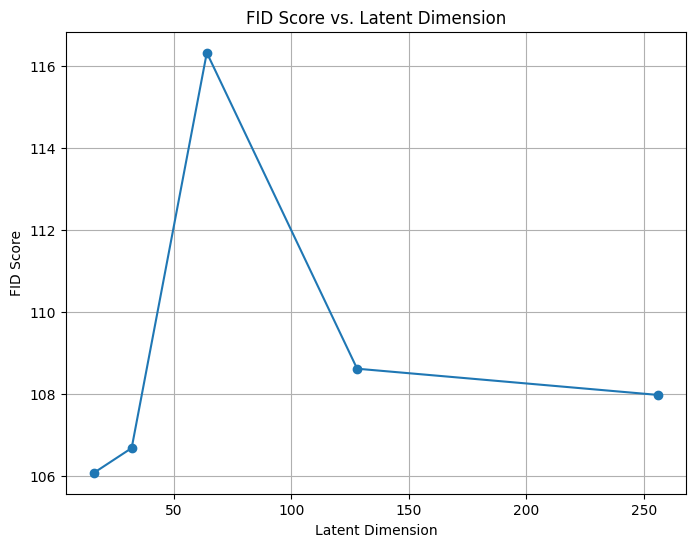

In [9]:
plt.figure(figsize=(8,6))
plt.plot(list(fid_results.keys()), list(fid_results.values()), marker='o')
plt.xlabel("Latent Dimension")
plt.ylabel("FID Score")
plt.title("FID Score vs. Latent Dimension")
plt.grid(True)
plt.show()

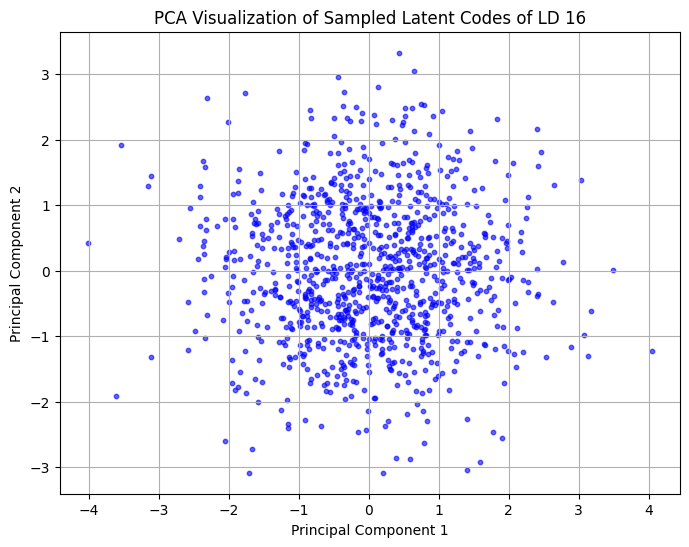

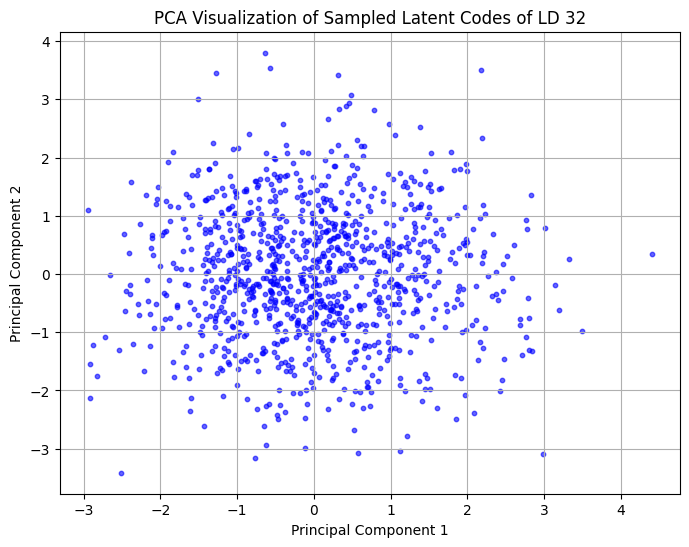

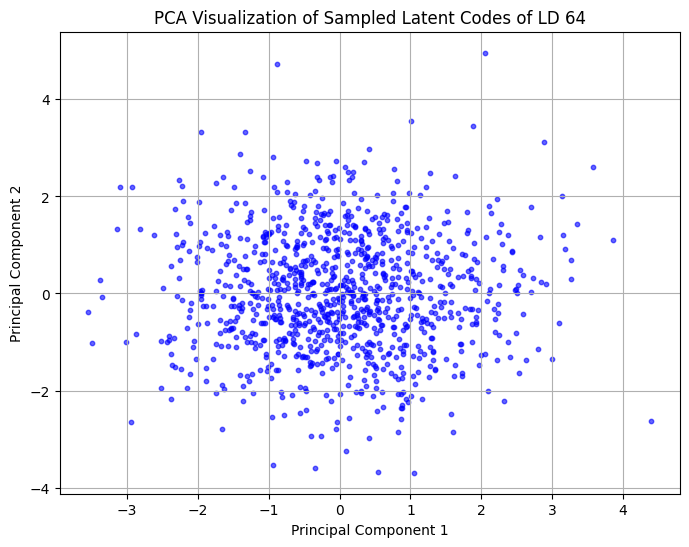

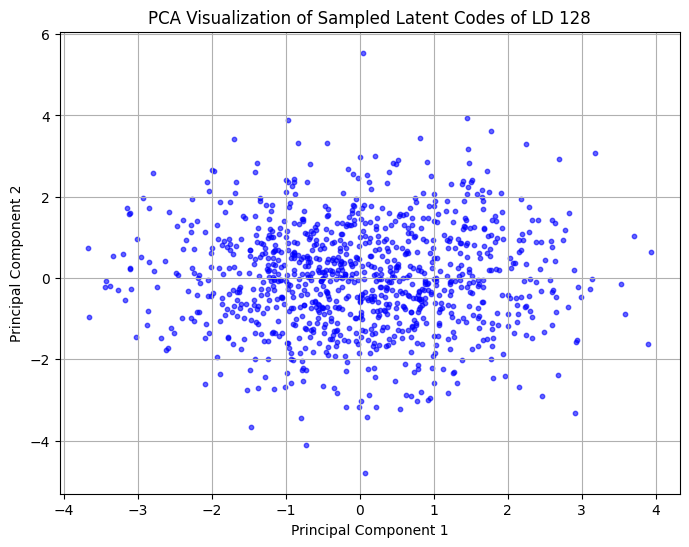

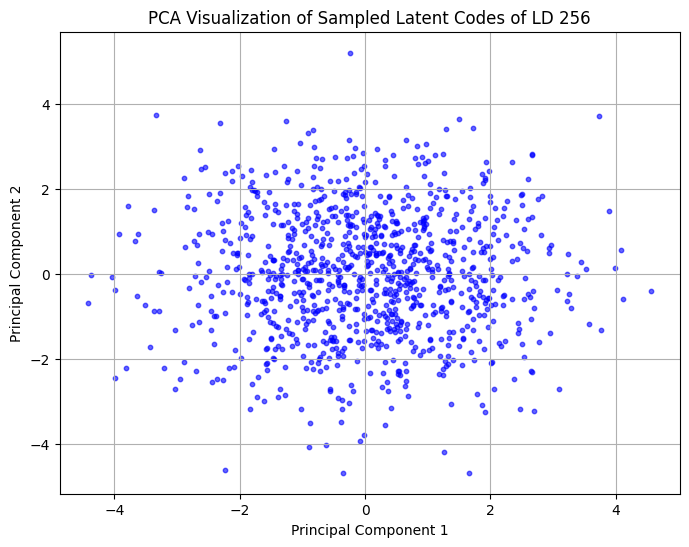

In [11]:
from sklearn.decomposition import PCA

for ld in latent_dims:
    num_samples = 1000 # Number of latent vectors to sample

    latent_vectors = torch.randn(num_samples, ld)
    latent_vectors_np = latent_vectors.cpu().numpy()

    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_vectors_np)

    plt.figure(figsize=(8, 6))
    plt.scatter(latent_2d[:, 0], latent_2d[:, 1], alpha=0.6, s=10, color='blue')
    plt.title(f"PCA Visualization of Sampled Latent Codes of LD {ld}")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)
    plt.show()